In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections4")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [2]:
bp = '/home/storage/hans/jax_reco_gupta_corrections4/examples/scripts/'

In [3]:
data = np.load(bp+'results_seed_smpe.npy')

In [4]:
data.shape

(202092, 21)

In [5]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [14]:
def get_gcd(results, result_idx=14):
    reco_zenith, reco_azimuth = results[:, result_idx], results[:, result_idx+1]
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [15]:
def get_resolution(results, result_idx=14):
    gcd, gcd_smpe, muon_energy = get_gcd(results, result_idx=result_idx)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [21]:
r_seed_smpe, r_smpe, xvals = get_resolution(data, result_idx=15)

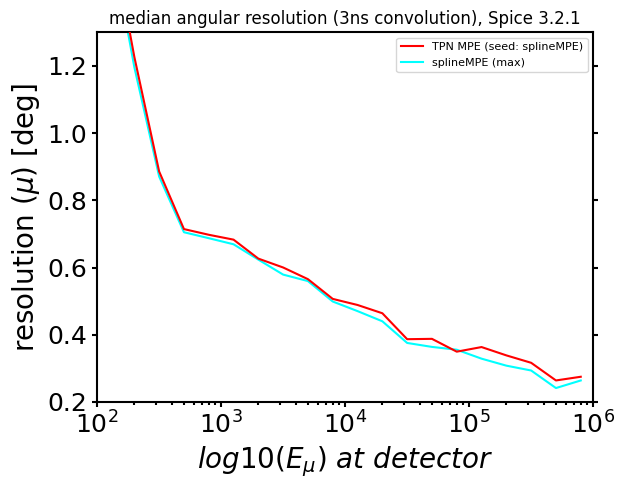

In [30]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.2, 1.3]}

ax.plot(10**xvals, r_seed_smpe[1], color='red', label='TPN MPE (seed: splineMPE)', linestyle='solid', zorder=17)
ax.plot(10**xvals, r_smpe[1], color='cyan', label='splineMPE (max)')

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution (3ns convolution), Spice 3.2.1')
ax.set_yticks([0.2*i for i in range(9)][1:-2])
plt.legend(fontsize=8, loc='upper right')
plt.show()

In [32]:
gcd, gcd_smpe, _ = get_gcd(data, result_idx=15)

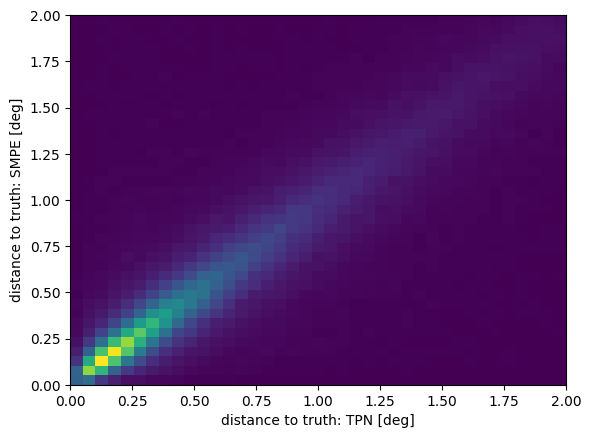

In [44]:
bins = np.linspace(0.0, 2.0, 40)
plt.hist2d(gcd, gcd_smpe, bins=bins)
plt.xlabel("distance to truth: TPN [deg]")
plt.ylabel("distance to truth: SMPE [deg]")
plt.show()

Text(0, 0.5, 'distance to truth: SMPE [deg]')

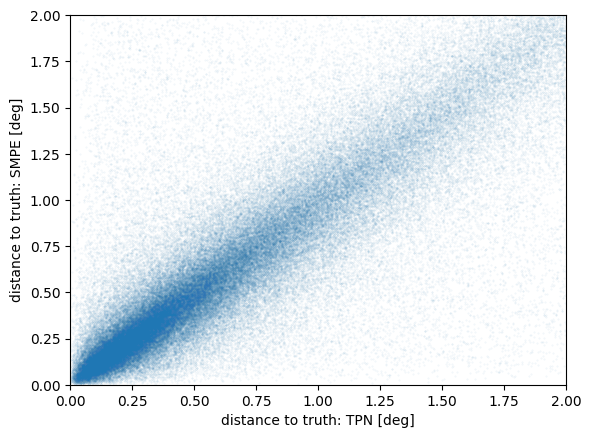

In [45]:
plt.scatter(gcd, gcd_smpe, s=0.1, alpha=0.1)
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 2.0)
plt.xlabel("distance to truth: TPN [deg]")
plt.ylabel("distance to truth: SMPE [deg]")